In [17]:
#this notebook reads the experimental and simulation data from a defined directory
#then a fitting on all data is performed using the best regularization type and strength
#ultimately the correction parameters also published in this study are obtained

In [18]:
import bussilab 
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy
from scipy.optimize import minimize
import cudamat as cm
import concurrent.futures
kBT=0.6 #kBT in kcal/mol
np.random.seed(1995)

In [19]:
def concatenate_simulation_data(files):
    result=None
    for t in files:
        if result is None:
            result=np.load(t)
            output=+result
        else:
            result=np.load(t)
            output=np.concatenate((output,result))

    return output

def read_TLs(files):
    corr=[]
    for file in files:
        with open(file, "r") as f:
            for line in f:
                nums=line.split()
                if nums:
                    corr.append(np.array([float(i) for i in nums]))
    return np.array(corr)

In [20]:
def calculate_TL_bias(Sequence,key,prune,skip,trajGAGA,FFprefactorsGAGA,trajUUCG,FFprefactorsUUCG):
    
    directories=["nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping", 
                 "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping_bias-from-half-half",
                 "nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping_bias-from-one-zero",
                 "nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping"
                 ]

    collection_weights=[]
    for index,d in enumerate(directories):
        Metadweight=[]
        with open("./data_loaded/%s/%s/weights.rep0" %(Sequence,d) ,"r") as fp:
            for line in fp:
                Metadweight.append(float(line))
        collection_weights.append(np.array(Metadweight))

    MetadPot1=np.concatenate((collection_weights[0],collection_weights[1]))
    MetadPot2=np.concatenate((collection_weights[2],collection_weights[3]))

    MetadPot=np.c_[ MetadPot1,MetadPot2 ] 
    MetadPot=kBT*np.log(MetadPot)
    
    if prune==True:
        MetadPot=MetadPot[::skip,:]
    
    if Sequence=='GAGA':
        if key == 'reference':
            bias=np.matmul(trajGAGA,np.array(FFprefactorsGAGA).T)+MetadPot
        if key == 'proposed':
            bias=np.matmul(trajGAGA,(FFprefactorsGAGA-FFprefactorsGAGA[1]).T)+MetadPot
        
    if Sequence=='UUCG':
        if key == 'reference':
            bias=np.matmul(trajUUCG,np.array(FFprefactorsUUCG).T)+MetadPot
        if key == 'proposed':
            bias=np.matmul(trajUUCG,(FFprefactorsUUCG-FFprefactorsUUCG[1]).T)+MetadPot
        

    del MetadPot1
    del MetadPot2
    del MetadPot
        
    return bias   

In [21]:
def activate_cuda(traj,weights, USE_CUDA):

    if USE_CUDA:
        cm.init(max_ones=traj.shape[0])
        cm_traj=cm.CUDAMatrix(traj.T)
        cm_weights=cm.CUDAMatrix(np.reshape(weights,(1,-1)))
        return cm_traj, cm_weights
    else:
        return traj,weights

def compute_newweights(par,cm_traj,cm_weights,USE_CUDA):
    if USE_CUDA:
        cm_par=cm.CUDAMatrix(np.reshape(par,(1,-1)))
        cm_correction=cm.dot(cm_par,cm_traj)
        
        m=float(cm_correction.min(axis=1).asarray()[0,0])
        cm_correction.subtract(m)
        cm_correction.mult(-1.0)
        newweights=cm.exp(cm_correction)
        newweights.mult_by_row(cm_weights)
        newweights.mult(1.0/(cm.sum(newweights,axis=1).asarray()[0,0]))
        return newweights 
    else:
        correction=np.matmul(cm_traj,par)
        correction-=np.min(correction)
        newweights=np.exp(-correction)*cm_weights
        return newweights/np.sum(newweights)
    
def function(par,obs,newweights,traj,cm_traj,USE_CUDA):
    gradient=True
    if USE_CUDA:
        if(isinstance(obs,cm.CUDAMatrix)):
            cm_obs=obs
        else:
            cm_obs=cm.CUDAMatrix(obs)
        if(isinstance(newweights,cm.CUDAMatrix)):
            cm_newweights=newweights
        else:
            cm_newweights=cm.CUDAMatrix(np.reshape(newweights,(1,-1)))
        av_obs=np.reshape(np.array(cm.dot(cm_newweights,cm_obs).asarray()),(-1))
    else:
        av_obs=np.reshape(np.array(np.matmul(newweights,obs)),(-1))
    
    if not gradient:
        return av_obs
    
    dav=np.zeros((len(par),obs.shape[1]))
    
    if USE_CUDA:
        cm_traj_weighted=cm.empty((traj.shape[1],traj.shape[0]))
        cm_traj_weighted.assign(cm_traj)
        cm_traj_weighted.mult_by_row(cm_newweights)
        av_traj=np.reshape(cm_traj_weighted.sum(axis=1).asarray(),(-1))
        dav=-cm.dot(cm_traj_weighted,cm_obs).asarray()
    else:
        weighted_traj=np.copy(traj)
        for ipar in range(len(par)):
            weighted_traj[:,ipar]=newweights*traj[:,ipar]
        av_traj=np.matmul(newweights,traj)
        for ipar in range(len(par)):
            for iobs in range(obs.shape[1]):
                dav[ipar,iobs]=-np.sum(weighted_traj[:,ipar]*obs.T[iobs,:])

    for ipar in range(len(par)):
        for iobs in range(obs.shape[1]):
            dav[ipar,iobs]+=av_obs[iobs]*av_traj[ipar]
            
    return av_obs,dav

In [22]:
def _logsum(ns):
    max = np.max(ns)
    ds = ns - max
    sumOfExp = np.exp(ds).sum()
    return max + np.log(sumOfExp)

In [23]:
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [24]:
def func_and_grad(par,noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,regularization,alpha,gradient=True,regularize=True,components=False):
    func=0.0
    chi2_native_GAGA=0.0
    chi2_native_UUCG=0.0
    chi2_noe=0.0
    chi2_unoe=0.0
    chi2_backbone1=0.0
    chi2_backbone2=0.0
    chi2_sugar=0.0
    
    if gradient:
        grad=np.zeros(len(par))
        grad_backbone1=np.zeros(len(par))
        grad_backbone2=np.zeros(len(par))
        grad_sugar=np.zeros(len(par))
        grad_noe=np.zeros(len(par))
        grad_unoe=np.zeros(len(par))
        grad_native_GAGA=np.zeros(len(par))
        grad_native_UUCG=np.zeros(len(par))
    
    
    
    USE_CUDA=True
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])
    
    funcGAGA=0.0
    gradGAGA=np.zeros(len(par))
    if obs_weight[0] != 0:
        chi2_native_GAGA=0.0
        cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        f=function(par,populationGAGA,w, trajGAGA,cm_traj, USE_CUDA)
        target_population=0.5
        diff=np.log(f[0]+eps)-np.log(target_population)
        if(diff<.0):
                chi2_native_GAGA+=diff**2
                if gradient:
                    grad_native_GAGA+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
        funcGAGA=obs_weight[0]*TLweight*chi2_native_GAGA
        if gradient:
            gradGAGA=obs_weight[0]*TLweight*grad_native_GAGA
        
    
    funcUUCG=0.0
    gradUUCG=np.zeros(len(par))
    if obs_weight[1] != 0:
        chi2_native_UUCG=0.0
        cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
        w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)

        f=function(par,populationUUCG,w, trajUUCG,cm_traj, USE_CUDA)
        target_population=0.5
        diff=np.log(f[0]+eps)-np.log(target_population)
        if(diff<.0):
                chi2_native_UUCG+=diff**2
                if gradient:
                    grad_native_UUCG+=np.matmul(f[1], 2*(np.log(f[0]+eps)-np.log(target_population))/(f[0]+eps))
        funcUUCG=obs_weight[1]*TLweight*chi2_native_UUCG
        if gradient:
            gradUUCG=obs_weight[1]*TLweight*grad_native_UUCG
    
    func+=prefactor*(funcGAGA+funcUUCG)
    if gradient:
        grad+=prefactor*(gradGAGA+gradUUCG)
    
    USE_CUDA=True
    cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
    w=compute_newweights(par,cm_traj,cm_weights,USE_CUDA)
    
    if obs_weight[2] != 0:
        f=function(par,noe,w, trajGACC,cm_traj, USE_CUDA)
        chi2_noe=np.sum(((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1])**2)/noe_exp.shape[0]
        func+=obs_weight[2]*noe_exp.shape[0]*chi2_noe
        if gradient:
            grad_noe+=np.matmul(f[1],(2/noe_exp.shape[0] * ((f[0]**(-1/6)-noe_exp[:,0])/noe_exp[:,1]) * (-1/6) * f[0]**(-7/6))/noe_exp[:,1])
            grad+=obs_weight[2]*noe_exp.shape[0]*grad_noe
    
    if obs_weight[3] != 0:
        f=function(par,unoe,w, trajGACC,cm_traj, USE_CUDA)
        chi2_unoe=0.0
        for i in range(len(f[0])):
            diff=f[0][i]**(-1/6)-unoe_exp[i,0]
            if(diff<.0):
                chi2_unoe+=(diff/unoe_exp[i,1])**2/unoe_exp.shape[0]
                if gradient:
                    grad_unoe+=f[1][:,i]*2/unoe_exp.shape[0]* diff/unoe_exp[i,1]* (-1/6) * f[0][i]**(-7/6) /unoe_exp[i,1]
        func+=obs_weight[3]*unoe_exp.shape[0]*chi2_unoe
        if gradient:
            grad+=obs_weight[3]*unoe_exp.shape[0]*grad_unoe
    
    if obs_weight[4] != 0:
        f=function(par,backbone1,w, trajGACC,cm_traj, USE_CUDA)
        chi2_backbone1=np.sum(((f[0]-backbone1_exp[:,0])/backbone1_exp[:,1])**2)/backbone1_exp.shape[0]
        func+=obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1
        if gradient:
            grad_backbone1+=np.matmul(f[1],2/backbone1_exp.shape[0] * (f[0]-backbone1_exp[:,0])/backbone1_exp[:,1]/backbone1_exp[:,1])
            grad+=obs_weight[4]*backbone1_exp.shape[0]*grad_backbone1
    
    if obs_weight[5] != 0:
        f=function(par,backbone2,w, trajGACC,cm_traj, USE_CUDA)
        chi2_backbone2=np.sum(((f[0]-backbone2_exp[:,0])/backbone2_exp[:,1])**2)/backbone2_exp.shape[0]
        func+=obs_weight[5]*backbone2_exp.shape[0]*chi2_backbone2
        if gradient:
            grad_backbone2+=np.matmul(f[1],2/backbone2_exp.shape[0] * (f[0]-backbone2_exp[:,0])/backbone2_exp[:,1]/backbone2_exp[:,1])
            grad+=obs_weight[5]*backbone2_exp.shape[0]*grad_backbone2
    
    if obs_weight[6] != 0:
        f=function(par,sugar,w, trajGACC,cm_traj, USE_CUDA)
        chi2_sugar=np.sum(((f[0]-sugar_exp[:,0])/sugar_exp[:,1])**2)/sugar_exp.shape[0]
        func+=obs_weight[6]*sugar_exp.shape[0]*chi2_sugar
        if gradient:
            grad_sugar+=np.matmul(f[1],2/sugar_exp.shape[0] * (f[0]-sugar_exp[:,0])/sugar_exp[:,1]/sugar_exp[:,1])
            grad+=obs_weight[6]*sugar_exp.shape[0]*grad_sugar
    
    denominator=(obs_weight[0]*TLweight+obs_weight[1]*TLweight+obs_weight[2]*noe_exp.shape[0]+obs_weight[3]*unoe_exp.shape[0] + obs_weight[4]*backbone1_exp.shape[0]+ obs_weight[5]*backbone2_exp.shape[0]+obs_weight[6]*sugar_exp.shape[0])
    func/=denominator
    
    
    if gradient:
        grad/=denominator
    
    if regularize:
        if regularization == 'L1':
            regL1=alpha * np.sum(np.sqrt(eps+par**2))
            func+=regL1
            if gradient:
                grad_regL1=(alpha*par)/(np.sqrt(eps+par**2))
                grad+=grad_regL1


        if regularization == 'L2':
            regL2=alpha * np.sum(par**2)
            func+=regL2
            if gradient:
                grad_regL2=2*alpha*par
                grad+=grad_regL2

        if regularization == 'KishSize':
            USE_CUDA=True
            cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
            wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            t=[trajGACC, trajGAGA, trajUUCG] 
            w_list=[weightsGACC, weightsGAGA, weightsUUCG]
            new_weights=[wGACC,wGAGA,wUUCG]
            
            
            kish=np.sum((new_weights[0]**2))
            kish_GAGA=np.sum((new_weights[1]**2))
            kish_UUCG=np.sum((new_weights[2]**2))
            
            kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))
            chi2_kish=alpha*kish_size
            func+=chi2_kish

            if gradient:
                grad_array=[0.0,0.0,0.0]

                for index,elem in enumerate(new_weights):
                    w_i=(elem**2)
                    c_a_i=t[index]
                    c_ave=np.matmul(new_weights[index],c_a_i)
                    grad_array[index]=-2*alpha*np.matmul(w_i,(c_a_i - c_ave)) 
                    grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]
                    
                grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)
                
        if regularization == 'RelativeKishSize':
            USE_CUDA=True
            cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
            wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            t=[trajGACC, trajGAGA, trajUUCG] 
            w_list=[weightsGACC, weightsGAGA, weightsUUCG]
            new_weights=[wGACC,wGAGA,wUUCG]

            Nf_list=[len(trajGACC),len(trajGAGA),len(trajUUCG)]
            kish=np.sum((eps+(new_weights[0]**2))/(eps+w_list[0]))/Nf_list[0]
            kish_GAGA=np.sum((eps+(new_weights[1]**2))/(eps+w_list[1]))/Nf_list[1]
            kish_UUCG=np.sum((eps+(new_weights[2]**2))/(eps+w_list[2]))/Nf_list[2]

            kish_size=_logsum(np.array([kish,kish_GAGA,kish_UUCG]))

            chi2_kish=alpha*kish_size
            func+=chi2_kish

            if gradient:
                grad_array=[0.0,0.0,0.0]

                for index,elem in enumerate(new_weights):
                    w_i=eps+(elem**2)
                    w_i/=(eps+w_list[index])
                    c_a_i=t[index]

                    c_ave=np.matmul(new_weights[index],c_a_i)
                    grad_array[index]=np.matmul(w_i,(c_a_i - c_ave))
                    grad_array[index]*=-(2*alpha)
                    grad_array[index]/=Nf_list[index]

                    grad_array[index]*=_softmax(np.array([kish,kish_GAGA,kish_UUCG]))[index]

                grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)

        if regularization == 'RelativeEntropy':
            USE_CUDA=True
            cm_traj, cm_weights,=activate_cuda(trajGACC,weightsGACC, USE_CUDA)
            wGACC=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
            wGAGA=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
            wUUCG=compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray()
            t=[trajGACC, trajGAGA, trajUUCG] 
            w_list=[weightsGACC, weightsGAGA, weightsUUCG]
            new_weights=[wGACC,wGAGA,wUUCG]

            entropy=np.exp(np.sum(new_weights[0]*np.log((new_weights[0])/(w_list[0])+eps)))
            entropy_GAGA=np.exp(np.sum(new_weights[1]*np.log((new_weights[1])/(w_list[1])+eps)))
            entropy_UUCG=np.exp(np.sum(new_weights[2]*np.log((new_weights[2])/(w_list[2])+eps)))

            relative_entropy=_logsum(np.array([entropy,entropy_GAGA,entropy_UUCG]))

            chi2_entropy=alpha*relative_entropy
            func+=chi2_entropy

            if gradient:
                grad_array=[0.0,0.0,0.0]

                for index,elem in enumerate(new_weights):
                    w_i=(elem) 
                    w_i_0=w_list[index]
                    c_a_i=t[index]
                    c_ave=np.matmul(eps+new_weights[index],c_a_i)
                    grad_array[index]=np.array([entropy,entropy_GAGA,entropy_UUCG])[index]

                    part1=-np.matmul(w_i*np.log((w_i/w_i_0)+eps),(c_a_i - c_ave))
                    part2=alpha*part1-alpha*np.matmul(w_i,(c_a_i - c_ave))
                    grad_array[index]*=part2

                    grad_array[index]*=_softmax(np.array([entropy,entropy_GAGA,entropy_UUCG]))[index]

                grad+=(np.sum(np.array(grad_array),axis=0)).reshape(12,)
    
    
    if gradient:
        return float(func), np.array(grad)        
    
    if components:
        chi2_native_GAGA=float(obs_weight[0]*TLweight*chi2_native_GAGA)
        chi2_native_UUCG=float(obs_weight[1]*TLweight*chi2_native_UUCG)
        chi2_noe=float(obs_weight[2]*noe_exp.shape[0]*chi2_noe)
        chi2_unoe=float(obs_weight[3]*unoe_exp.shape[0]*chi2_unoe)
        chi2_backbone1=float(obs_weight[4]*backbone1_exp.shape[0]*chi2_backbone1)
        chi2_backbone2=float(obs_weight[4]*backbone2_exp.shape[0]*chi2_backbone2)
        chi2_sugar=float(obs_weight[5]*sugar_exp.shape[0]*chi2_sugar)
        
        return float(func), chi2_backbone1/denominator,chi2_backbone2/denominator,chi2_sugar/denominator,chi2_noe/denominator,chi2_unoe/denominator, chi2_native_GAGA/denominator,chi2_native_UUCG/denominator  
    
    return float(func)

In [25]:
def save_single_min(data):
    
    chi2_col=data[1]
    chi2_ref_col=data[2]
    chi2_native_GAGA_col=data[3]
    chi2_native_UUCG_col=data[4]
    chi2_noes_col=data[5]
    chi2_unoes_col=data[6]
    chi2_sugar_col=data[7]
    chi2_backbone1_col=data[8]
    chi2_backbone2_col=data[9]
    populationGAGA_col=data[10]
    populationUUCG_col=data[11]
    
    temp=np.array([chi2_col,
chi2_ref_col,
chi2_native_GAGA_col,
chi2_native_UUCG_col,
chi2_noes_col,
chi2_unoes_col,
chi2_sugar_col,
chi2_backbone1_col,
chi2_backbone2_col,
populationGAGA_col,
populationUUCG_col],dtype='object')
    
    #comment out the following section for the CVSystem execution run
    np.save("./data_produced/chi2.npy",temp)
    lambdas = np.asarray(data[0])
    np.save("./data_produced/parameters.npy", lambdas)
    
    #uncomment the following section for the CVSystem execution run without bounds
    #np.save("./data_produced/SingleMinimization_errors_None.npy",temp)
    #lambdas = np.asarray(data[0])
    #np.save("./data_produced/SingleMinimization_Lambdas_None.npy", lambdas)
    
    #uncomment the following section for the CVSystem execution run with bounds
    #np.save("./data_produced/SingleMinimization_bounds_errors_None.npy",temp)
    #lambdas = np.asarray(data[0])
    #np.save("./data_produced/SingleMinimization_bounds_Lambdas_None.npy", lambdas)

In [26]:
def reorder(input_array):
    
    temp=input_array
    
    input_array=np.array([temp[1],temp[4],temp[3],temp[5],temp[0],temp[2],temp[7],temp[10],temp[9],temp[11],temp[6],temp[8]])
    
    return input_array

def opt_func_plumed(rdist):
    
        r0=1
        d0=0.2
        dmax=0.3
        c=0.8
        rdist=(rdist-d0)*1/r0

        dmax2=dmax-d0

        A = (-c*dmax2*dmax2)/((1-c)*dmax2*dmax2)
        B = (2*dmax2)/((1-c)*dmax2*dmax2)   
        C = -1/((1-c)*dmax2*dmax2)
        D = 1/(c*dmax2*dmax2)

        scale=1

        if (rdist > dmax2):
            result=0.0
            return result
        if (rdist <= 0): 
            result=-1.0
        else:
            result=-1.0
            if rdist > c*(dmax2): 
                result+=(A + B*rdist + C*rdist*rdist)
            elif rdist > 0 : 
                result+=D*(rdist*rdist) 


        result*=scale


        return result

In [27]:
def main():
    
    print("Load experimental data")
    noe_exp=np.loadtxt("./data_loaded/GACC/exp_noes",usecols=(2,3))
    unoe_exp=np.loadtxt("./data_loaded/GACC/exp_unobs-noes",usecols=(2,3))
    sugar_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-sugar",usecols=(1,2))
    backbone1_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-1",usecols=(1,2))
    backbone2_exp=np.loadtxt("./data_loaded/GACC/exp_jcoupl-backbone-2",usecols=(1,2))
    print(noe_exp.shape)
    print(unoe_exp.shape)
    print(sugar_exp.shape)
    print(backbone1_exp.shape)
    print(backbone2_exp.shape)
    print('There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.')
    
    #get the names of the different simulations and there forcefield prefactors
    trajectoryNamesGACC=[]
    trajectoryNamesGAGA=[]
    trajectoryNamesUUCG=[]
    FFprefactorsGACC=[]
    FFprefactorsGAGA=[]
    FFprefactorsUUCG=[]

    with open("./data_loaded/coefficients.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            l=line.split()
            file=l[0]+".skip.npy"
            trajectoryNamesGACC.append(file)
            FFprefactorsGACC.append(np.array(np.array(l)[1:],dtype='float'))

    with open("./data_loaded/coefficients_TLs.dat","r") as fp:
        for line in fp:
            if(line[0]=='#'):
                continue
            if line.strip():
                l=line.split()
                file=l[0]+".npy"
                if 'gaga' in line:
                    FFprefactorsGAGA.append(np.array(l[1:],dtype='float'))
                if 'uucg' in line:
                    FFprefactorsUUCG.append(np.array(l[1:],dtype='float'))

    firstFF='nh-n_0.5_nh-o_0.5_oh-bo-nbO_-0.5_dumping/'
    secondFF='nh-n_1.0_nh-o_0.0_oh-bo-nbO_-0.5_dumping/'
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesGAGA.append('./data_loaded/GAGA/'+secondFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+firstFF+'gHBfix-parameters_state.rep0')
    trajectoryNamesUUCG.append('./data_loaded/UUCG/'+secondFF+'gHBfix-parameters_state.rep0')

    #-------------------------------------------------------------------------------
    #load observables
    print('There are 14 simulations for GACC.')

    trajGACC=concatenate_simulation_data(['./data_loaded/GACC/' + x for x in trajectoryNamesGACC])
    backbone1=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-1",x) for x in trajectoryNamesGACC])
    backbone2=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_backbone-2",x) for x in trajectoryNamesGACC])
    sugar=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","jcop_sugar",x) for x in trajectoryNamesGACC])
    noe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","noe",x) for x in trajectoryNamesGACC])
    unoe=concatenate_simulation_data(['./data_loaded/GACC/' + re.sub("HBfix-energy","unoe",x) for x in trajectoryNamesGACC])

    #apply forward models
    sugar=9.67*np.cos(sugar*np.pi/180)**2 - 2.03*np.cos(sugar*np.pi/180)
    backbone1=9.7*np.cos(backbone1*np.pi/180)**2 - 1.8*np.cos(backbone1*np.pi/180)
    backbone2=15.3*np.cos(backbone2*np.pi/180)**2 - 6.1*np.cos(backbone2*np.pi/180)+1.6
    noe=noe**-6
    unoe=unoe**-6
    print('There are 2 simulations per TL.')
    trajGAGA=read_TLs([x for x in trajectoryNamesGAGA])
    trajUUCG=read_TLs([x for x in trajectoryNamesUUCG])
    populationGAGA=trajGAGA[:,-1].reshape(-1,1)
    populationUUCG=trajUUCG[:,-1].reshape(-1,1)
    trajGAGA=trajGAGA[:,:12]
    trajUUCG=trajUUCG[:,:12]

    #to obtain the same parameters as published set prune=False
    prune=False
    if prune==True:
        skip=5000
        print("Pruning data, skip")
        trajGACC=trajGACC[::skip,:]
        backbone1=backbone1[::skip,:]
        backbone2=backbone2[::skip,:]
        sugar=sugar[::skip,:]
        noe=noe[::skip,:]
        unoe=unoe[::skip,:]
        populationGAGA=populationGAGA[::skip,:]
        populationUUCG=populationUUCG[::skip,:]
        trajGAGA=trajGAGA[::skip,:]
        trajUUCG=trajUUCG[::skip,:]
    else:
        skip=0

    print("Check shape of arrays:")
    print(trajGACC.shape)
    print(backbone1.shape)
    print(backbone2.shape)
    print(sugar.shape)
    print(noe.shape)
    print(unoe.shape)
    print(populationGAGA.shape)
    print(populationUUCG.shape)
    print(trajGAGA.shape)
    print(trajUUCG.shape)
    
    
    def wham(bias_ff,frame_weight=None,traj_weight=None,T=1.0,maxit=1000,threshold=1e-40,verbose=False):
        """WHAM tool

           bias_ff[i,j] is the potential applied on frame i by Hamiltonian j
           Returns an array with the weight of each frame

        """
        import numpy as np
        # allow lists
        if not isinstance(bias_ff, (np.ndarray, np.generic) ):
            bias_ff=np.array(bias_ff)

        nframes=bias_ff.shape[0]
        ntraj=bias_ff.shape[1]

        # default values
        if frame_weight is None:
            frame_weight=np.ones(nframes)
        if traj_weight is None:
            traj_weight=np.ones(ntraj)

        assert(len(traj_weight)==ntraj)
        assert(len(frame_weight)==nframes)

        # do exponentials only once
        expv=np.exp((-bias_ff+np.min(bias_ff))/T)

        Z=np.ones(ntraj)
        Zold=np.copy(Z)

        if(verbose):
            print("WHAM: start")
        for it in range(maxit):
            weight=1.0/np.matmul(expv,traj_weight/Z)
            weight/=np.sum(weight*frame_weight)
            Z=np.matmul(frame_weight*weight,expv)
            Z/=np.sum(Z*traj_weight)
            eps=np.sum(np.log(Z/Zold)**2)
            Zold=Z
            if verbose:
                print("WHAM: iteration",it,"eps",eps)
            if(eps<threshold):
                break
        if(verbose):
            print("WHAM: end")
        return weight*frame_weight
    
    weightsGACC=wham(np.matmul(trajGACC,np.transpose(FFprefactorsGACC-FFprefactorsGAGA[1])),verbose=False,threshold=1e-20,T=kBT)
    weightsGAGA=wham(calculate_TL_bias('GAGA','proposed',prune,skip,trajGAGA,FFprefactorsGAGA,trajUUCG,FFprefactorsUUCG),verbose=False,threshold=1e-20,T=kBT)
    weightsUUCG=wham(calculate_TL_bias('UUCG','proposed',prune,skip,trajGAGA,FFprefactorsGAGA,trajUUCG,FFprefactorsUUCG),verbose=False,threshold=1e-20,T=kBT)

    bounds=[]
    for i in range(12):
        bounds.append((-1.666666666666666,+1.666666666666666)) #bounds in kbT units set to -1 to 1 in kcal/mol

    eps=1e-30

    prefactor=1.0
    TLweight=(noe_exp.shape[0]+unoe_exp.shape[0] + backbone1_exp.shape[0]+ backbone2_exp.shape[0]+sugar_exp.shape[0])

    

    #regularization_list=['None','L1','L2','KishSize','RelativeKishSize','RelativeEntropy']
    regularization_list=['RelativeKishSize']
    regularization='RelativeKishSize'
    alpha=0.0
    
    #uncomment the following line for the CVSystem execution run with and without bounds
    #regularization_list=['None']

    alpha_star_list=[18.679135990207847] #alpha* for RelativeKishSize regularization identified in this study

    obs_weight=[1.0,1.0,1.0,1.0,1.0,1.0,1.0]
    ref_chi2=func_and_grad(np.zeros(12),noe_exp,unoe_exp,sugar_exp,backbone1_exp,backbone2_exp,trajGACC,backbone1,backbone2,sugar,noe,unoe,trajGAGA,trajUUCG,weightsGACC,weightsGAGA,weightsUUCG,eps,prefactor,TLweight,obs_weight,populationGAGA,populationUUCG,regularization,alpha,gradient=False,regularize=False,components=False)
    print(ref_chi2)

    chi2_col=[]
    chi2_ref_col=[]
    chi2_native_GAGA_col=[]
    chi2_native_UUCG_col=[]
    chi2_noes_col=[]
    chi2_unoes_col=[]
    chi2_sugar_col=[]
    chi2_backbone1_col=[]
    chi2_backbone2_col=[]
    populationGAGA_col=[]
    populationUUCG_col=[]
    collection=[]
    for r,reg in enumerate(regularization_list):
        regularization=reg
        print(regularization)

        alpha=alpha_star_list[r]
        print(alpha)

        #comment the 'bounds=bounds' in following line for the CVSystem execution run without bounds
        m=minimize(func_and_grad,x0=np.zeros(12), args=(noe_exp,
unoe_exp,
sugar_exp,
backbone1_exp,
backbone2_exp,
trajGACC,
backbone1,
backbone2,
sugar,
noe,
unoe,
trajGAGA,
trajUUCG,
weightsGACC,
weightsGAGA,
weightsUUCG,
eps,
prefactor,
TLweight,
obs_weight,
populationGAGA,
populationUUCG,
regularization,
alpha), method='L-BFGS-B', jac=True,bounds=bounds)
        print(m.message, m.success)
        print(m.x)

        collection.append(list(m.x))

        t_chi2, t_chi2_backbone1,  t_chi2_backbone2, t_chi2_sugar, t_chi2_noes,  t_chi2_unoes, t_chi2_native_GAGA,t_chi2_native_UUCG  =func_and_grad(m.x,noe_exp,
unoe_exp,
sugar_exp,
backbone1_exp,
backbone2_exp,
trajGACC,
backbone1,
backbone2,
sugar,
noe,
unoe,
trajGAGA,
trajUUCG,
weightsGACC,
weightsGAGA,
weightsUUCG,
eps,
prefactor,
TLweight,
obs_weight,
populationGAGA,
populationUUCG,
regularization,
alpha,gradient=False,regularize=False,components=True)

        chi2_col.append(t_chi2)
        chi2_ref_col.append(ref_chi2)

        chi2_native_GAGA_col.append(t_chi2_native_GAGA)
        chi2_native_UUCG_col.append(t_chi2_native_UUCG)
        chi2_noes_col.append(t_chi2_noes)
        chi2_unoes_col.append(t_chi2_unoes)
        chi2_sugar_col.append(t_chi2_sugar)
        chi2_backbone1_col.append(t_chi2_backbone1)
        chi2_backbone2_col.append(t_chi2_backbone2)

        par=m.x
        USE_CUDA=True

        cm_traj, cm_weights,=activate_cuda(trajGAGA,weightsGAGA, USE_CUDA)
        new_weights=np.reshape(compute_newweights(par,cm_traj,cm_weights,USE_CUDA).asarray(),(-1,))  

        cm_traj, cm_weights,=activate_cuda(trajUUCG,weightsUUCG, USE_CUDA)
        new_weights=np.reshape(compute_newweights(par,cm_traj,cm_weights,True).asarray(),(-1,)) 

        populationGAGA_col.append(np.matmul(new_weights,populationGAGA))
        populationUUCG_col.append(np.matmul(new_weights,populationUUCG))

    save_list=[collection,
    chi2_col,
    chi2_ref_col,
    chi2_native_GAGA_col,
    chi2_native_UUCG_col,
    chi2_noes_col,
    chi2_unoes_col,
    chi2_sugar_col,
    chi2_backbone1_col,
    chi2_backbone2_col,
    populationGAGA_col,
    populationUUCG_col] 
    save_single_min(save_list)
    
    

In [28]:
executor=concurrent.futures.ProcessPoolExecutor(max_workers=1)
future = executor.submit(main)

Load experimental data
(20, 2)
(285, 2)
(12, 2)
(8, 2)
(9, 2)
There are no experimental population data for the TLs. The population is enforced to be 0.5 in the cost function.
There are 14 simulations for GACC.
There are 2 simulations per TL.
Check shape of arrays:
(1400000, 12)
(1400000, 8)
(1400000, 9)
(1400000, 12)
(1400000, 20)
(1400000, 285)
(1000000, 1)
(1000000, 1)
(1000000, 12)
(1000000, 12)
21.803205490112305
RelativeKishSize
18.679135990207847
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH' True
[-1.66666667 -1.08691868  0.20668562 -1.66666667  1.29619341 -1.66666667
 -1.66666667  1.41575784 -1.66666667 -1.66666667  1.4333629  -1.60218027]


In [30]:
print(future)

<Future at 0x7f409435ffa0 state=running>


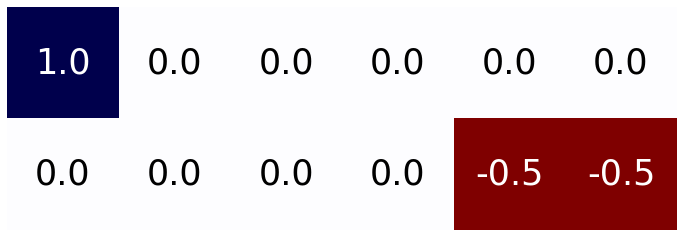

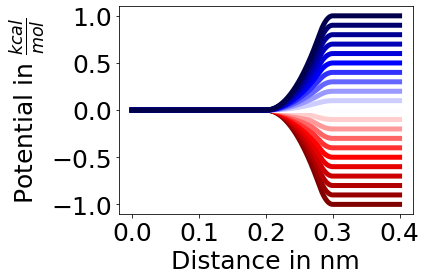

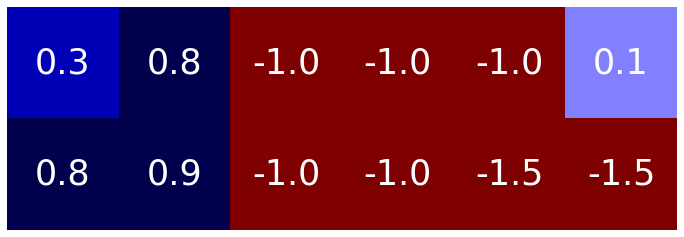

In [31]:
#in kcal/mol

gHBfix=[]
for i in range(12):
    gHBfix.append(0.0)

gHBfix[1]=1.0
gHBfix[6]=-0.5
gHBfix[8]=-0.5
gHBfix=reorder(gHBfix)  
data=[gHBfix]
cmap = plt.cm.get_cmap('gist_gray')

for l,lambdas in enumerate(data):
    newlambdas = data[l].reshape(-1,12)
    l=newlambdas[0].reshape(2,6)
    image = plt.matshow(l,cmap='seismic_r',vmin=-0.5,vmax=0.5)
    for (i, j), z in np.ndenumerate(l):
        if z > 0:
            c='white'
        elif z == 0:
            c='black'
        else:
            c='white'
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=35, color=c)
    plt.axis('off')
    plt.show()


cmap = plt.cm.get_cmap('seismic_r')
#cmap = plt.cm.get_cmap('seismic')
plt.figure()

count=0
for eta in range(-10,11):
    c=cmap(count/20)
    eta/=10
    x=np.linspace(0,0.4,500)
    y=[]
    for e in x:
        y.append(((opt_func_plumed(e))+1)*eta)
    plt.plot(x,y,linewidth=5,color=c)

    count+=1
#plt.xlabel('Distance in $\AA$', fontsize=16)
plt.xlabel('Distance in nm', fontsize=25)
plt.locator_params(nbins=7)
#plt.ylabel('gHBfix potential in kcal/mol', fontsize=16)
plt.ylabel(r'Potential in $\frac{kcal}{mol}$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

error= np.load('./data_produced/chi2.npy',allow_pickle=True)
lambdas = np.load('./data_produced/parameters.npy',allow_pickle=True)

gHBfix=[]
for i in range(12):
    gHBfix.append(0.0)

gHBfix[1]=1.0
gHBfix[6]=-0.5
gHBfix[8]=-0.5
gHBfix=np.array(gHBfix)   
data=lambdas /1.666666666666666
data=data+gHBfix
cmap = plt.cm.get_cmap('gist_gray')

for l,lambdas in enumerate(data):
    newlambdas = reorder(data[l]).reshape(-1,12)
    l=newlambdas[0].reshape(2,6)
    plt.matshow(l,cmap='seismic_r',vmin=-0.5,vmax=0.5)
    for (i, j), z in np.ndenumerate(l):
        c='white' 
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=35, color=c)
    plt.axis('off')
    plt.show()

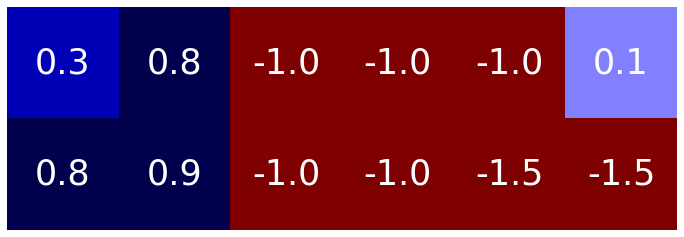

In [32]:
error= np.load('./data_produced/Prepared_chi2.npy',allow_pickle=True)

lambdas = np.load('./data_produced/Prepared_parameters.npy',allow_pickle=True)

gHBfix=[]
for i in range(12):
    gHBfix.append(0.0)

gHBfix[1]=1.0
gHBfix[6]=-0.5
gHBfix[8]=-0.5
gHBfix=np.array(gHBfix)   
data=lambdas /1.666666666666666
data=data+gHBfix
cmap = plt.cm.get_cmap('gist_gray')

for l,lambdas in enumerate(data):
    newlambdas = reorder(data[l]).reshape(-1,12)
    l=newlambdas[0].reshape(2,6)
    plt.matshow(l,cmap='seismic_r',vmin=-0.5,vmax=0.5)
    for (i, j), z in np.ndenumerate(l):
        c='white' 
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=35, color=c)
    plt.axis('off')
    plt.show()